In [9]:
import pandas as pd
from pathlib import Path
import sys
sys.path.append('..')

## Make df of straws from file

In [39]:
# organized by their panel; includes batch, position number
straw_list_file = Path("straws_on_panels.csv")
assert straw_list_file.is_file()
straws_df = pd.read_csv(straw_list_file, sep=",")
#straws_list = np.loadtxt(straw_list_file, delimiter=",", dtype=int, skiprows=1, usecols=range(1))
straws_df.columns = straws_df.columns.str.replace(" ", "")
straws_df = straws_df.rename(columns={"id": "straw"})
straws_df

,number,pos,straw,batch,present
0,191,0,22439,120617B5,1.0
1,191,1,22343,120517B1,1.0
2,191,2,22300,113017B4,1.0
3,191,3,22463,120717B2,1.0
4,191,4,22438,120617B5,1.0
5,191,5,22342,120517B1,1.0
6,191,6,22318,113017B4,1.0
7,191,7,22462,120717B2,1.0
8,191,8,22437,120617B5,1.0
9,191,9,22341,120517B1,1.0


## Refit function

In [11]:
import guis.straw.leak.straw_leak_utilities as util
from guis.straw.leak.least_square_linear import get_fit

In [12]:
# Skip points at beginning and end
def truncate(container, nstart, nend):
    return container[max(nstart - 1, 0) : len(container) - nend]

In [13]:
class NotEnoughData(Exception):
    pass

In [14]:
# We won't use the skip-start/endpoints functionality, but leaving it around just in case.
def refit(raw_data_file_fullpath, n_skips_start = 0, n_skips_end = 0):
    leak_rate = 0
    leak_rate_err = 0

    slope = []
    slope_err = []
    intercept = []
    intercept_err = []

    # Get data from raw data file
    timestamp, ppm, ppm_err = util.get_data_from_file(raw_data_file_fullpath)

    timestamp = truncate(timestamp, n_skips_start, n_skips_end)
    ppm = truncate(ppm, n_skips_start, n_skips_end)
    ppm_err = truncate(ppm_err, n_skips_start, n_skips_end)

    # not enough data
    if not timestamp:
        raise NotEnoughData
        
    # Calculate slopes, leak rates
    raw_data_filename = raw_data_file_fullpath.name
    try:
        chamber = int(raw_data_filename[15:17])
    except:
        chamber = int(raw_data_filename[15:16])
    slope, slope_err, intercept, intrcept_err = get_fit(timestamp, ppm, ppm_err)

    leak_rate = util.calculate_leak_rate(slope, util.get_chamber_volume(chamber))

    leak_rate_err = util.calculate_leak_rate_err(
        leak_rate,
        slope,
        slope_err,
        util.get_chamber_volume(chamber),
        util.get_chamber_volume_err(chamber),
    )

    # pass, fail, or unknown
    leak_status = util.evaluate_leak_rate(len(ppm), leak_rate, leak_rate_err, timestamp[-1])

    #print("\n  Status leak rate after refit:", leak_status)

    return leak_rate, leak_rate_err, leak_status

## Raw data location

In [15]:
from guis.common.getresources import GetProjectPaths
# straw leak raw data location
indir = GetProjectPaths()["strawleakdata"] / "raw_data"
print(indir)

/Users/Ben/Home/Working/mu2e-tracker-factory/data/StrawLeak/raw_data


## DF of {straw, raw data file, fit value, fit error, fit status}

In [48]:
import importlib
importlib.reload(util)
# one row for each file – many rows for one straw are allowed.
file_list = []
for raw_data_file in indir.glob("*.txt"):
    straw = str(raw_data_file.name)[2:7]
    
    #if straw != "23839":
    #    continue
        
    try:
        straw = int(straw)
    except ValueError:
        print("BAD FILE (FILENAME)", raw_data_file.name)
        continue

    try:
        leak_rate, leak_rate_err, leak_status = refit(raw_data_file)
    except NotEnoughData:
        continue
    except IndexError as e:
        print("BAD FILE (INDEX)", e, raw_data_file.name)
    except ValueError as e:
        print("BAD FILE (VALUE)", raw_data_file.name)
        continue
        
    file_list.append(
        {
            'straw':straw,
            'leak_data_file':str(raw_data_file),
            'rate': leak_rate,
            'rate_err':leak_rate_err,
            'status':leak_status
        }
    )
file_df = pd.DataFrame(file_list)  
file_df

BAD FILE (VALUE) ST17028_chamber11_2021_06_25_rawdata.txt
BAD FILE (VALUE) ST24897_chamber20_2022_01_28_rawdata.txt
BAD FILE (VALUE) ST99005_chamber24_2021_06_25_rawdata.txt
BAD FILE (VALUE) ST99002_chamber9_2021_06_25_rawdata.txt
BAD FILE (FILENAME) ST4163_chamber15_2021_06_17_rawdata.txt


,leak_data_file,rate,rate_err,status,straw
0,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,7.333726e-05,(9.530288227282682e-06+0j),PassFailStatus.PASS,28107
1,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,5.880449e-05,(5.917143990309048e-06+0j),PassFailStatus.PASS,81015
2,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,8.666446e-05,(5.078454713147631e-06+0j),PassFailStatus.PASS,23399
3,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,1.108931e-04,(9.791905627332542e-06+0j),PassFailStatus.UNKNOWN,9628
4,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,6.545611e-05,(9.969003709731003e-06+0j),PassFailStatus.UNKNOWN,28141
5,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,5.194911e-05,(7.1958772366592254e-06+0j),PassFailStatus.PASS,18839
6,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,3.689100e-05,(4.911087521858245e-06+0j),PassFailStatus.PASS,21164
7,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,5.891327e-05,(2.924519186277179e-06+0j),PassFailStatus.PASS,17201
8,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,4.604752e-05,(7.906261431338136e-06+0j),PassFailStatus.PASS,24808
9,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,4.541589e-05,(6.907507014206427e-06+0j),PassFailStatus.PASS,26822


## Clean data – remove negative rates, failed tests. Keep smallest rate.

In [109]:
# show straws with multiple tests
df = file_df.rename_axis(None)
df[df.straw.duplicated(keep=False)].sort_values(by=['straw'])

,leak_data_file,rate,rate_err,status,straw
4782,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,7.451430e-05,(4.464692150858386e-06+0j),PassFailStatus.PASS,597
1414,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,4.094147e-05,(6.3595831005159245e-06+0j),PassFailStatus.PASS,597
1120,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,6.641748e-05,(7.99424855570733e-06+0j),PassFailStatus.PASS,813
1850,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,2.990365e-03,(7.985771012243708e-05+0j),PassFailStatus.FAIL,813
8379,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,2.789674e-03,(9.564482467924181e-05+0j),PassFailStatus.FAIL,828
20,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,8.571107e-17,(0.000587124425667436+0j),PassFailStatus.UNKNOWN,828
9763,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,5.863591e-05,(8.379575580613088e-06+0j),PassFailStatus.PASS,863
2896,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,7.906997e-04,(2.0541460871834096e-05+0j),PassFailStatus.FAIL,863
13094,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,1.239922e-04,(8.839964031254318e-06+0j),PassFailStatus.FAIL,873
728,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,2.472792e-04,(1.0517362890072827e-05+0j),PassFailStatus.FAIL,873


In [110]:
# remove negative leak values
df.drop(df[ df['rate'] < 0 ].index , inplace=True)

# remove failed tests
df.drop(df[ df['status'] == "PassFailStatus.FAIL"].index , inplace=True)

# only keep the tests with the smallest leaks
df = df.groupby('straw', group_keys=False).apply(lambda x: x.loc[x.rate.idxmin()])

In [111]:
# show that we've removed all but the smallest rates
df = df.rename_axis(None)
df[df.straw.duplicated(keep=False)].sort_values(by=['straw'])

,leak_data_file,rate,rate_err,status,straw


In [112]:
# about 3000 duplicates removed
df

,leak_data_file,rate,rate_err,status,straw
53,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,7.940945e-05,(5.1455682022421735e-06+0j),PassFailStatus.PASS,53
61,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,1.644772e-03,(5.35127703773851e-05+0j),PassFailStatus.FAIL,61
62,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,5.631397e-05,(3.918778195836765e-06+0j),PassFailStatus.PASS,62
68,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,7.273100e-05,(8.65601745754515e-06+0j),PassFailStatus.PASS,68
266,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,2.331096e-05,(5.851456400162101e-06+0j),PassFailStatus.PASS,266
597,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,4.094147e-05,(6.3595831005159245e-06+0j),PassFailStatus.PASS,597
813,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,6.641748e-05,(7.99424855570733e-06+0j),PassFailStatus.PASS,813
823,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,3.914005e-03,(0.00014868329842404927+0j),PassFailStatus.FAIL,823
827,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,4.689078e-03,(0.00011197553051076498+0j),PassFailStatus.FAIL,827
828,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,8.571107e-17,(0.000587124425667436+0j),PassFailStatus.UNKNOWN,828


In [233]:
import matplotlib.pyplot as plt
from numpy.testing import suppress_warnings
from numpy import ComplexWarning

## Merge the straws-by-panel df with the leak rate-by-straw df

In [113]:
final_df = straws_df.merge(df, on=['straw'], how = 'left')
final_df

,number,pos,straw,batch,present,leak_data_file,rate,rate_err,status
0,191,0,22439,120617B5,1.0,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000048,(4.322583085152338e-06+0j),PassFailStatus.PASS
1,191,1,22343,120517B1,1.0,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000064,(4.21584594571463e-06+0j),PassFailStatus.PASS
2,191,2,22300,113017B4,1.0,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000070,(4.573843151311583e-06+0j),PassFailStatus.PASS
3,191,3,22463,120717B2,1.0,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000067,(4.244918619091237e-06+0j),PassFailStatus.PASS
4,191,4,22438,120617B5,1.0,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000037,(4.818693736539374e-06+0j),PassFailStatus.PASS
5,191,5,22342,120517B1,1.0,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000066,(4.39845345656218e-06+0j),PassFailStatus.PASS
6,191,6,22318,113017B4,1.0,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000064,(3.078773431802786e-06+0j),PassFailStatus.PASS
7,191,7,22462,120717B2,1.0,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000045,(3.906388223831282e-06+0j),PassFailStatus.PASS
8,191,8,22437,120617B5,1.0,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000042,(4.5540084793298235e-06+0j),PassFailStatus.PASS
9,191,9,22341,120517B1,1.0,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000061,(4.1826751448851565e-06+0j),PassFailStatus.PASS


## Sum leak rates by panel

In [244]:
fig, ax = plt.subplots(1, 1)
final_df.groupby(['number'])['rate'].sum().plot(kind="bar", figsize=(15,8),ax=ax)
ax.set_ylabel("integrated straw leaks",fontsize=20)
ax.set_xlabel("panel",fontsize=20)
#ax.set_title("all panels",fontsize=25)
fig.savefig(f"summed_straw_leaks_by_panel.png")
plt.close(fig)

## Mean leak rates by panel

In [245]:
fig, ax = plt.subplots(1, 1)
ax = final_df.groupby(['number'])['rate'].mean().plot(kind="bar", figsize=(15,8))
ax.set_ylabel("mean straw leak rate",fontsize=20)
ax.set_xlabel("panel",fontsize=20)
fig.savefig(f"mean_straw_leak_rate_per_panel.png")
plt.close()

## Median leak rates by panel

In [247]:
fig, ax = plt.subplots(1, 1)
ax = final_df.groupby(['number'])['rate'].median().plot(kind="bar", figsize=(15,8))
ax.set_ylabel("median straw leak rate",fontsize=20)
ax.set_xlabel("panel",fontsize=20)
fig.savefig(f"median_straw_leak_rate_per_panel.png")
plt.close()

## all straw leaks across all panels

In [239]:
fig, ax = plt.subplots(1, 1)
final_df.plot.scatter(ax = ax, x='pos',y='rate',ylim=(-2e-5,22e-5),figsize=(15,10))
ax.set_ylabel("individual straw leak rate",fontsize=25)
ax.set_xlabel("straw position on panel",fontsize=25)
ax.set_title("all panels",fontsize=25)
fig.savefig(f"all_straw_leaks_by_position.png")
plt.close(fig)

In [172]:
#final_df[final_df['number']==192][['pos','rate']]

,pos,rate
96,0,0.000050
97,1,0.000045
98,2,0.000035
99,3,0.000065
100,4,0.000037
101,5,0.000044
102,6,0.000049
103,7,0.000062
104,8,0.000048
105,9,0.000039


## straw leaks distribution by panel

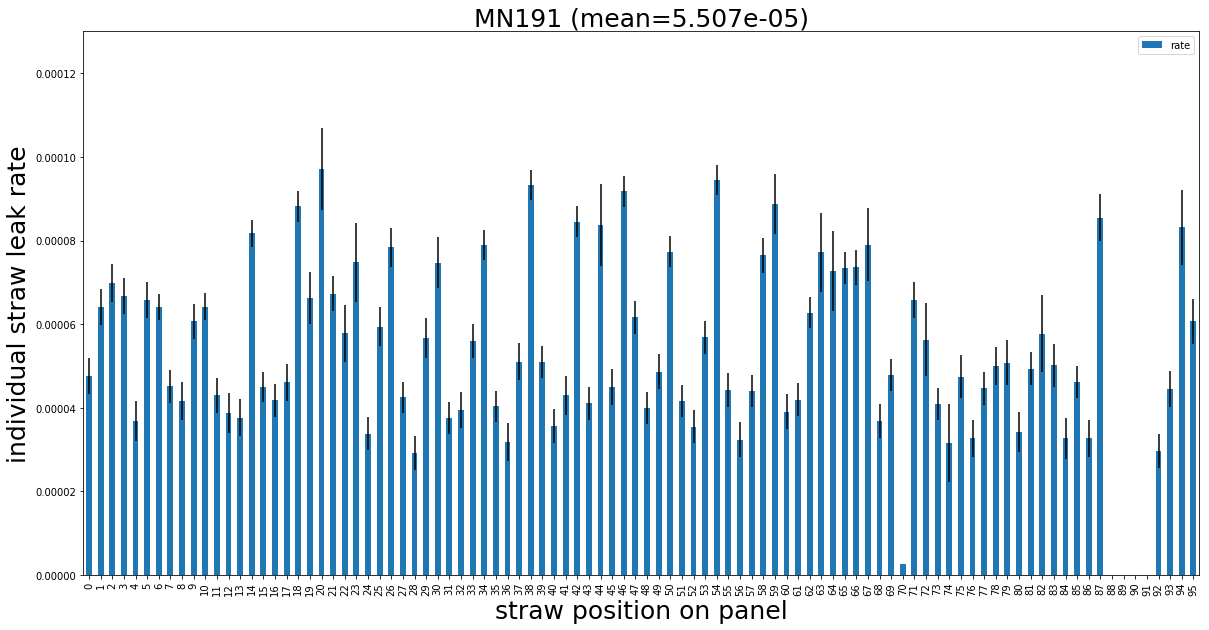

In [235]:
for panel in range(191,230):
    fig, ax = plt.subplots(1, 1)
    try:
        with suppress_warnings() as sup:
            sup.filter(ComplexWarning)
            # bar
            final_df[final_df['number']==panel][['pos','rate','rate_err']].plot(
                x='pos',y='rate',
                yerr='rate_err',
                kind="bar", 
                figsize=(20,10), ax = ax,ylim=(0,13e-5)
            )
            
            # scatter (eww)
            #final_df[final_df['number']==panel][['pos','rate','rate_err']].plot(
            #    x='pos',y='rate',
            #    yerr='rate_err',
            #    kind="scatter", 
            #    figsize=(20,10), ax = ax,ylim=(0,13e-5),s=60
            #)
    except TypeError:
        print("NO DATA",panel)
        plt.close(fig)
        continue
    except ValueError:
        print("problem?",panel)
        plt.close(fig)
        continue
    
    # calculate mean
    heights = final_df[final_df['number']==panel]['rate']
    freq = heights.value_counts().sort_index()
    freq_frame = freq.to_frame()
    mean = round(heights.mean(),8)
    median = heights.median()
    
    ax.set_ylabel("individual straw leak rate",fontsize=25)
    ax.set_xlabel("straw position on panel",fontsize=25)
    ax.set_title(f'MN{panel} (mean={mean})',fontsize=25)
    fig.savefig(f"MN{panel}_bar.png")
    plt.close(fig)